In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
import logging
import geopandas as gpd
import folium

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler


In [16]:
# Utilization
date=6
def create_dict(row):
    dict = [0]*24
    for hour in range(24):
        if (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']==hour): 
            dict[hour] = 60-row['arr_time'].minute
        elif  (row['park_end_day']>date) & (row['arr_hour']==hour)&(row['arr_time'].day==date):
            dict[hour] = 60-row['arr_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']<hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_time'].day<date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']==hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute-row['arr_time'].minute
        else:
            dict[hour]=0
    return dict

def soe_init(row):
    soe_init={}
    for hour in range(24):
        if row['arr_time'].day<date:
            soe_init[hour] = row['SoE_bc']
        elif (hour<=row["arr_hour"]) and (row['arr_time'].day==date):
            soe_init[hour]=row['SoE_bc']
        else:
            soe_init[hour]=0
    return soe_init

def create_charge_time_list(row):
    charge_time_list = [0]*24
    if row['c']:
        st_chg = row['st_chg_time'].hour
        ed_chg = row['ed_chg_time'].hour
        for t in range(24):
            if (st_chg==t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute-row['st_chg_time'].minute
            elif (st_chg<t) & (ed_chg>t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = 60
            elif (st_chg<t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute
            elif (st_chg==t) & (((ed_chg>t) & (row['ed_chg_time'].day == date))|(row['ed_chg_time'].day>date)):
                charge_time_list[t] = 60-row['st_chg_time'].minute
            elif (st_chg<t) & (row['ed_chg_time'].day>date):
                charge_time_list[t]=60
            else:
                charge_time_list[t]=0
    return charge_time_list

In [17]:
df = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
df['dep_time'] = pd.to_datetime(df['dep_time'],format='mixed')
df['arr_time'] = pd.to_datetime(df['arr_time'],format='mixed')
df['st_chg_time'] = pd.to_datetime(df['st_chg_time'],format='mixed')
df['ed_chg_time'] = pd.to_datetime(df['ed_chg_time'],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')

df['dep_hour'] = df['dep_time'].dt.hour
df['arr_hour'] = df['arr_time'].dt.hour
df.sort_values(by=['person','dep_time'])
df['next_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)

d = df[(df['grid'] == "369_0") & ((df['type_day'] == 'Thursday') | (df['type_day'] == 'Friday'))]
d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
d.loc[d['type_day'] == 'Friday', 'arr_time'] = d.loc[d['type_day'] == 'Friday', 'arr_time'].apply(lambda dt: dt.replace(day=6, month=5, year=2050))
d.loc[d['type_day'] == 'Thursday', 'arr_time'] = d.loc[d['type_day'] == 'Thursday', 'arr_time'].apply(lambda dt: dt.replace(day=5, month=5, year=2050))
d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
d['park_end_hour'] = d['park_end_time'].dt.hour
d['park_end_day'] = d['park_end_time'].dt.day
d.loc[:, 'st_chg_time'] = d.apply(lambda row: row['st_chg_time'].replace(day=row['arr_time'].day, month=row['arr_time'].month, year=row['arr_time'].year), axis=1)
d['ed_chg_time'] = d['st_chg_time']+d['chg_time']
d['chg_time'] = d['chg_time'].dt.total_seconds()/60
d = d[(d['park_end_time']>='2050-05-06 00:00:00') & (d['arr_time']<'2050-05-07 00:00:00')]
d.insert(0,'event_index',d.index)
d['max_chg_e'] = d['B']-d['SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['SoE_bc']
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x), axis =1)
d['soe_init'] = d.apply(lambda x:soe_init(x), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_11650/691524322.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_11650/691524322.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_11650/691524322.py:18: SettingWithCopyWarnin

<Axes: >

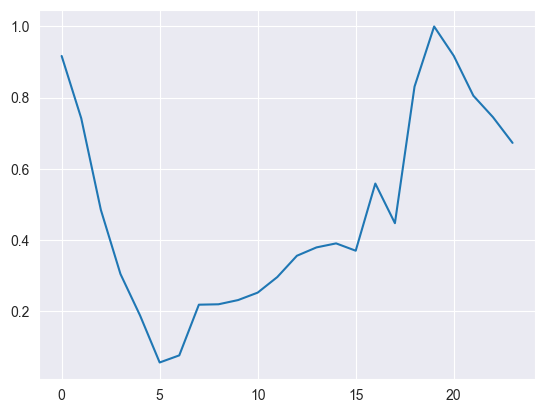

In [18]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
tomatch = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/HV_emob_load_2050.csv") # in MW
tomatch.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
tomatch = tomatch.loc[(tomatch.ts<"2050-05-07 00:00:00") & (tomatch.ts>="2050-05-06 00:00:00")][['ts','peak',hv_bus]]
day_max = tomatch[hv_bus].max()
day_min = tomatch[hv_bus].min()
day_sum = tomatch[hv_bus].sum()
tomatch['normalized_profile']=tomatch[hv_bus]/day_max
tomatch.index=range(24)
tomatch['normalized_profile'].plot()

In [162]:
# mobility = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
# mobility['dep_time'] = pd.to_datetime(mobility['dep_time'],format='mixed')
# mobility['arr_time'] = pd.to_datetime(mobility['arr_time'],format='mixed')
# mobility['st_chg_time'] = pd.to_datetime(mobility['st_chg_time'],format='mixed')
# mobility['ed_chg_time'] = pd.to_datetime(mobility['ed_chg_time'],format='mixed')
# mobility['chg_time'] = pd.to_timedelta(mobility['ed_chg_time']-mobility['st_chg_time'],unit='m')
# 
# mobility['dep_hour'] = mobility['dep_time'].dt.hour
# mobility['arr_hour'] = mobility['arr_time'].dt.hour
# mobility.sort_values(by=['person','dep_time'])
# mobility['next_travel_TP1_consumption'] = mobility.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)
# 
# inbound = mobility[(mobility['grid']=="369_0") & (mobility['type_day']=="Friday")]
# inbound['arr_time'] = inbound['dep_time'] + pd.to_timedelta(inbound['trav_time'], unit='m')
# inbound['arr_time'] = inbound['arr_time'].apply(lambda dt:dt.replace(day=6,month=5,year=2050))
# inbound['st_chg_time'] = inbound['st_chg_time'].apply(lambda dt:dt.replace(day=6,month=5,year=2050))
# inbound['ed_chg_time'] = inbound['st_chg_time']+inbound['chg_time']
# inbound['chg_time'] = inbound['chg_time'].dt.total_seconds()/60
# 
# inbound['park_end_time'] = inbound['arr_time']+pd.to_timedelta(inbound['parking_time'],unit='m')
# inbound['park_end_hour'] = inbound['park_end_time'].dt.hour
# inbound['park_end_day'] = inbound['park_end_time'].dt.day
# inbound.insert(0,'event_index',inbound.index)
# inbound['max_chg_e'] = inbound['B']-inbound['SoE_bc']
# inbound['real_chg_e'] = inbound['SoE_ac']-inbound['SoE_bc']
# inbound['hourly_time_dict'] = inbound.apply(lambda x:create_dict(x), axis =1)
# inbound['soe_init'] = inbound.apply(lambda x:soe_init(x), axis =1)
# inbound['charge_time_list'] = inbound.apply(lambda x:create_charge_time_list(x), axis=1)
# inbound['charge_power_list'] = inbound.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
# inbound['charge_energy_list'] = inbound.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_23829/146034678.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inbound['arr_time'] = inbound['dep_time'] + pd.to_timedelta(inbound['trav_time'], unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_23829/146034678.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inbound['arr_time'] = inbound['arr_time'].apply(lambda dt:dt.replace(day=6,month=5,year=2050))
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_23829/1460

In [16]:
Kmeans Elbow Test
# 23961 original data, 4474 charging record
clustered = pd.DataFrame()
features = inbound[['end_x', 'end_y', 'parking_time','chg_time','next_travel_TP1_consumption']] # 'start_x', 'start_y', 'trav_time', 'traveled_distance', 'TP1 rate kWh/100 km','TP1 consumption kWh'
scaler = StandardScaler()
features_scaled= scaler.fit_transform(features)
# Calculate within-cluster sum of squares for different numbers of clusters
wcss=[]
test = [5,10,20,30,40,50,80,100,200,500,1000,2000]
for i in test:
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=100,random_state=0)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(test,wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within-cluster sum of squares
plt.xticks(test)

In [9]:
np.random.seed(42)
features = inbound[['end_x', 'end_y']] # 'start_x', 'start_y', 'trav_time', 'traveled_distance', 'TP1 rate kWh/100 km','TP1 consumption kWh','parking_time','next_travel_TP1_consumption'
scaler = StandardScaler()
features_scaled= scaler.fit_transform(features)
k = 25 # number of clusters
clustering_kmeans = KMeans(k, random_state=42)
cluster_labels = clustering_kmeans.fit_predict(features_scaled)
inbound['cluster'] = cluster_labels # assign label to original sample
clustered = inbound
clustered.head()

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_23829/3972612791.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inbound['cluster'] = cluster_labels # assign label to original sample


,event_index,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,...,park_end_hour,park_end_day,max_chg_e,real_chg_e,hourly_time_dict,soe_init,charge_time_list,charge_power_list,charge_energy_list,cluster
170,170,63620,2020-05-03 10:59:57,25.000000,30.753,work,leisure,2689194.0,1249241.0,2701360.0,...,11,6,25.96,0.00,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 94.04, 1: 94.04, 2: 94.04, 3: 94.04, 4: 94...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
313,313,94876,2020-05-03 13:32:23,66.400000,83.588,home,leisure,2724691.0,1220053.0,2697286.0,...,16,6,34.79,0.00,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 55.21, 1: 55.21, 2: 55.21, 3: 55.21, 4: 55...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18
388,388,109999,2020-05-03 07:44:30,90.750000,102.668,other,leisure,2729026.0,1220575.0,2701004.0,...,11,6,32.45,0.00,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 87.55, 1: 87.55, 2: 87.55, 3: 87.55, 4: 87...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
438,438,119166,2020-05-03 05:17:52,84.816667,111.438,home,work,2671710.0,1204953.0,2698392.0,...,19,6,35.06,35.06,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 18, 7:...","{0: 54.94, 1: 54.94, 2: 54.94, 3: 54.94, 4: 54...","[0, 0, 0, 0, 0, 0, 18, 60, 60, 53, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 11.0, 11.0, 11.0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3, 11.0, 11.0...",16
528,528,132589,2020-05-03 08:27:35,75.866667,108.772,home,work,2668547.0,1202971.0,2698392.0,...,17,6,36.10,0.00,"{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 53.9, 1: 53.9, 2: 53.9, 3: 53.9, 4: 53.9, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16


In [19]:
clustered = d.sort_values(by=['arr_time','parking_time'])
k = 25
group = np.arange(len(clustered)) % k
clustered['cluster']=group
path = ("bigM_netload_v14_0p1charge")

In [61]:
def opt_charge_profile(tomatch,cluster,emob_max_p,normalized_tot_e,cluster_i,path):
    t_list = list(range(24))
    e_list = list(cluster.event_index)
    tomatch_t = tomatch['normalized_profile']
    
    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event set
    m.T = Set(initialize=t_list) # hour of the day
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=Reals,bounds=(-1,1),initialize=0) 
    m.ax_charge_power = Var(m.E, m.T, within=NonNegativeReals, bounds=(0, 1), initialize=0)
    m.is_parked = Var(m.E, m.T, within=Binary,initialize=0)
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_positive = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_negative = Var(m.E,m.T,within=Binary,initialize=0)
    m.change = Var(m.E,m.T, within=Binary,initialize=0)
    # Slack Variable
    # m.next_trip_s = Var(m.E,within=NonNegativeReals,initialize=0)
    m.power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals,bounds=(0,0.2*normalized_tot_e))
    m.energy_deficit = Var(within=NonNegativeReals,bounds=(0,0.2*normalized_tot_e))

    ###########################
    # Parameters
    load_to_match_dict = {t:tomatch_t[t] for t in t_list}
    m.load_to_match = Param(m.T,initialize=load_to_match_dict) # Normalized nexus profile
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normal scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW

    capacity = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    m.capacity = Param(m.E,initialize=capacity) # Normalized battery capacity
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict) # parking minutes within this hour
    
    next_trip_e_dict = {e:cluster.loc[e,'next_travel_TP1_consumption']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_hour_dict = {e:cluster.loc[e,'park_end_hour'] for e in e_list}
    m.park_end_hour = Param(m.E,initialize=park_end_hour_dict) # Park End Hour
    park_end_day = {e:cluster.loc[e,'park_end_day'] for e in e_list}
    m.park_end_day = Param(m.E, initialize=park_end_day)# Park End Day
    
    SoE_dict = {(e,t):cluster.loc[e,'soe_init'][t]/emob_max_p for e in e_list for t in t_list}
    m.SoE_2d = Param(m.E,m.T,initialize=SoE_dict,mutable=True) # initial SoE profile
    
    SoE_init= {e:cluster.loc[e,'SoE_bc']/emob_max_p for e in e_list}
    m.SoE_init = Param(m.E,initialize=SoE_init) # initial SoE profile
    
    max_chg_e_dict = {e:cluster.loc[e,'max_chg_e']/emob_max_p for e in e_list}
    m.max_chg_e = Param(m.E,initialize=max_chg_e_dict) # max energy to charge for each event 
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    charge_status_change = {e:0 for e in e_list}
    m.charge_status_change = Param(m.E, initialize=charge_status_change)
    
    ############################ 
    # enforce absolute value of charge_power    
    def ax_charge_power_constraint_upper(m, e, t):
        return m.charge_power[e,t]<=m.ax_charge_power[e,t]
    def ax_charge_power_constraint_lower(m, e, t):
        return -m.charge_power[e,t]<=m.ax_charge_power[e,t]
    m.ax_charge_power_upper = Constraint(m.E, m.T, rule=ax_charge_power_constraint_upper)
    m.ax_charge_power_lower = Constraint(m.E, m.T, rule=ax_charge_power_constraint_lower)
    
    def positive_charge_power_rule(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_positive[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule)

    def negative_charge_power_rule(m, e, t):
        return -m.charge_power[e, t] <= 1000000 * m.is_negative[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    
    def non_simultaneous_rule(m, e, t):
        return m.is_positive[e, t] + m.is_negative[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)
    
    # Enforce binary variable represent parking status
    def parking_logic_constraint(m, e, t):
        M = 1000000  
        return m.parking_time[e, t] <= M * m.is_parked[e, t]
    m.parking_logic = Constraint(m.E, m.T, rule=parking_logic_constraint)

    # Enforce binary variable represent charging status
    def charging_logic_constraint(m, e, t):
        M = 1000000  
        return m.ax_charge_power[e, t] <= M * m.is_charging[e, t]
    m.charging_logic = Constraint(m.E, m.T, rule=charging_logic_constraint)

    '''
    charging power limit
    '''
    def power_limit_rule(m,e,t):
        return  m.ax_charge_power[e, t] + m.power_limit_s[e,t] == m.max_power[e] * m.is_charging[e,t] #
    m.power_limit = Constraint(m.E, m.T, rule=power_limit_rule)

    def parking_rule(m,e,t):
        if m.parking_time[e,t]==0:
            return m.charge_power[e,t]==0
        else:
            return Constraint.Skip
    m.parking = Constraint(m.E,m.T,rule=parking_rule) 
    
    '''
    SoE non-negative
    '''
    # update SoE for event e at hour t
    def SoE_update_rule(m,e,t):
        if t==0:
            return m.SoE_2d[e,t]
        else:
            return m.SoE_update[e,t-1]+m.charge_power[e,t-1]*m.parking_time[e,t-1]
    m.SoE_update=Expression(m.E,m.T,rule=SoE_update_rule)
    
    # SoE shouldn't be negative:
    def SoE_nonnegative_rule(m,e,t):
        return m.SoE_update[e,t]>=0
    m.SoE_nonnegative = Constraint(m.E,m.T, rule=SoE_nonnegative_rule)
    
    def next_trip_rule(m,e,t):
        if (m.park_end_day[e]==date) and (t==m.park_end_hour[e]+1):
            return m.SoE_update[e,t] >= m.next_trip_e[e] # + m.next_trip_s[e]
        else:
            return Constraint.Skip
    m.SoE_nexttrip = Constraint(m.E,m.T,rule=next_trip_rule)

    # SoE does not exceed battery capacity
    def SoE_le_capacity_rule(m,e,t):
        return m.SoE_update[e,t]<=m.capacity[e]
    m.SoE_le_capacity = Constraint(m.E,m.T,rule=SoE_le_capacity_rule)
          
    '''
    Decreasing charging power by limiting current
    '''    
    def decrease_charge_power_rule_1(m,e,t):
        if t>0 and (m.parking_time[e,t]>=0):
            return (m.charge_power[e,t-1] - m.charge_power[e,t]) * m.is_positive[e,t-1]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge_power = Constraint(m.E,m.T,rule=decrease_charge_power_rule_1)
    # 
    # def decrease_charge_power_rule_2(m,e,t):
    #     if t>0 and (m.parking_time[e,t]>=0):
    #         return (m.charge_power[e,t] - m.charge_power[e,t-1]) * m.is_negative[e,t-1]>=0
    #     else:
    #         return Constraint.Skip
    # m.decreasing_charge_power = Constraint(m.E,m.T,rule=decrease_charge_power_rule_2)
    # 
    '''
    Avoid alternating charging direction
    '''
    def detect_change_rule_1(m,e,t):
        if t==0:
            return m.change[e,t]==0
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] <= 100000 * m.change[e,t]
    m.detect_change = Constraint(m.E,m.T,rule=detect_change_rule_1)
    def detect_change_rule_2(m,e,t):
        if t==0:
            return m.change[e,t]==0
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] >= -100000 * m.change[e,t]
    m.detect_change = Constraint(m.E,m.T,rule=detect_change_rule_2)
    
    def avoid_alternating_rule(m,e):
        return sum(m.change[e,t] for t in m.T)
    m.change_direction = Expression(m.E,rule=avoid_alternating_rule)
    
    def max_e_event_rule(m,e):
        return m.change_direction[e]<=6
    m.max_3_event = Constraint(m.E,rule=max_e_event_rule)
    
    def avoid_adj_alternating_rule(m,e,t):
        if t>0:
            return (m.is_positive[e,t-1]-m.is_negative[e,t-1])*(m.is_positive[e,t]-m.is_negative[e,t])>=0
        else:
            return Constraint.Skip
    m.avoid_adj_alternating = Constraint(m.E,m.T,rule=avoid_adj_alternating_rule)
    
    '''
    Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum(m.charge_power[e,t]*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit == m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    '''
    Charging Limit considering battery capacity
    '''
    # total energy requested from grid for this parking event
    def tot_e_required_rule(m,e):
        return sum(m.charge_power[e,t]*m.parking_time[e,t] for t in m.T)
    m.tot_e_required=Expression(m.E, rule=tot_e_required_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_net_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] for e in m.E )
    m.hourly_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.load_to_match[t]-m.hourly_tot_net_charge_power[t])**2 for t in m.T) + sum(1000*m.power_limit_s[e,t] for e in m.E for t in m.T)# + sum(m.change_direction[e] for e in m.E) 
    m.objective = Objective(rule=objective_rule, sense=minimize)
    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    # solver.options['tol'] = 0.0001
    solver.solve(m,tee=True)   #,keepfiles=True,logfile="match_profile_log.log")
    log_infeasible_constraints(m,log_expression=True, log_variables=True)
    logging.basicConfig(filename='v12.log', encoding='utf-8')
    # Save results
    res_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    res = pd.Series(res_dict).unstack()
    res.to_csv(f'{path}/369_0_cluster_{cluster_i}.csv')
    # slack_dict = {(e): m.next_trip_s[e].value*emob_max_p for e in m.E}
    # slack = pd.DataFrame(list(slack_dict.items()), columns=['Event', 'Slack Value'])
    # slack.to_csv(f'{path}/369_0_cluster_{cluster_i}_next_trip_violation.csv')
    return 0

In [62]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in [0]:
    
    cluster = clustered[clustered['cluster']==i]
    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW
    
    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)

    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)
    
    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        # plt.figure(figsize=(10,6))
        # plt.plot(emob_agg_p,label='power')
        # plt.plot(emob_agg_e,label='energy')
        # plt.legend()
        # plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:, 'normalized_chg_power'] = cluster['chg rate'] / emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        
        opt_res_code = opt_charge_profile(tomatch,cluster,emob_max_p,normalized_tot_e,i,path)

    else:
        index = list(cluster['event_index'])
        T = list(range(24))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')
        

Mobility data peak power: 339.0 Mobility data minimal power: 0 Mobility data total power: 3270.0
Mobility data peak energy: 349.4666666666667 Mobility data minimal energy: 3.033333333333333 Mobility data total energy: 3376.55


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_11650/3580143644.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:, 'normalized_chg_power'] = cluster['chg rate'] / emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpj1d7z20q.pyomo.lp
Reading time = 8.71 seconds
x1: 365675 rows, 247491 columns, 833414 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 365675 rows, 247491 columns and 833414 nonzeros
Model fingerprint: 0x841676e4
Model has 19953720 quadratic objective terms
Model has 59294 quadratic constraints
Variable types: 92811 continuous, 154680 integer (154680 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-01, 1e+03]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [6e-04, 1e+01]
Presolve removed 90061 rows and 63162 columns (presolve time = 2

In [8]:
agg_e = [sum(x) for x in zip(*d['charge_energy_list'])] # energy in kWh
agg_p = [sum(x) for x in zip(*d['charge_power_list'])] # power in kW
max_p,min_p,tot_p = max(agg_p), min(agg_p), sum(agg_p)
max_e, min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)
print(tot_e)

79894.16666666669


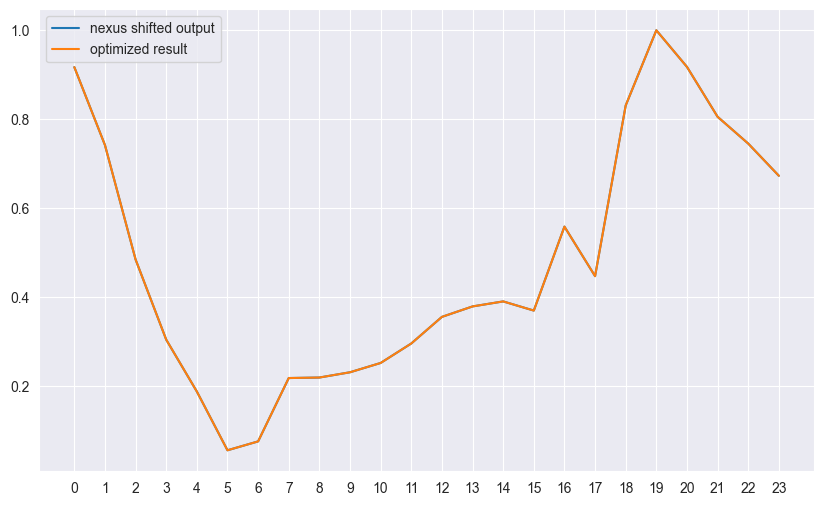

In [9]:
path = 'bigM_netload_v14_0p1charge'
concat_res = pd.DataFrame()
for i in range(k):
    cluster_i = pd.read_csv(f'{path}/369_0_cluster_{i}.csv')
    concat_res = pd.concat([concat_res,cluster_i],axis=0)
concat_res = concat_res.rename(columns={'Unnamed: 0':'event_index'})
concat_res.to_csv(f'{path}/concat_charge_power_all.csv')
concat_sum = concat_res.sum()[1:].sum()
concat_max = concat_res.sum()[1:].max()
plt.figure(figsize=(10,6))
plt.plot(tomatch['normalized_profile'],label='nexus shifted output')
plt.plot(concat_res.sum()[1:]/concat_max,label='optimized result')
plt.legend()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


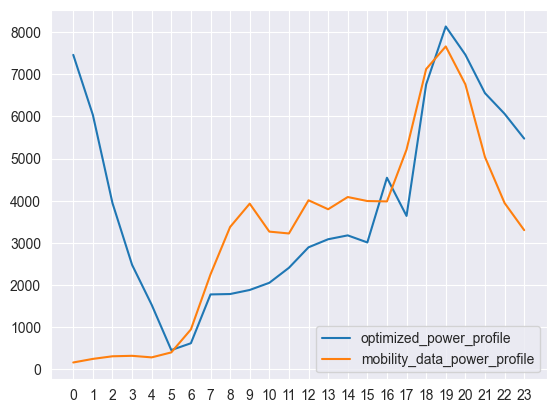

In [10]:
res_p = concat_res.sum()[1:]
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [11]:
concat_res

,event_index,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,6296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,7804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,21.481034,21.957677,21.797711,0.0,0.0
3,8135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.718046,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,8492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,1097974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1284,1098554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1285,1098578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1286,1098956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [12]:
concat_res = concat_res.set_index('event_index').sort_index()
time = pd.DataFrame(d['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_11650/4179871584.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)


In [13]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

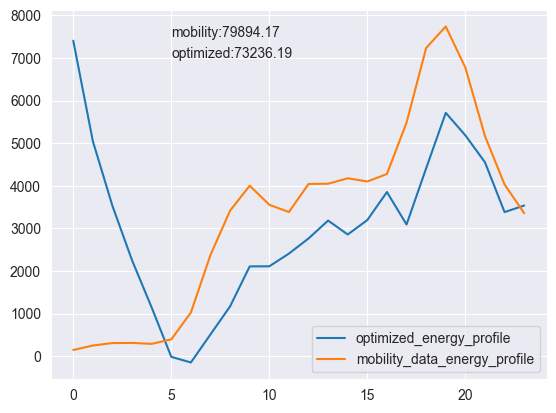

In [14]:
res_p = concat_res.sum()[1:]
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,7500,f'mobility:{tot_e:.2f}')
plt.text(5,7000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')

In [51]:
d.loc[d['event_index']==118154]

,event_index,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,...,park_end_time,park_end_hour,park_end_day,max_chg_e,real_chg_e,hourly_time_dict,soe_init,charge_time_list,charge_power_list,charge_energy_list
118154,118154,2552273,2020-05-03 06:18:02,14.05,14.51,home,work,2710660.0,1268219.0,2701612.0,...,2050-05-06 16:48:02,16,6,5.58,0.0,"[0, 0, 0, 0, 0, 0, 28, 60, 60, 60, 60, 60, 60,...","{0: 64.42, 1: 64.42, 2: 64.42, 3: 64.42, 4: 64...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
